# This is a program for tracking an object in one video

In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

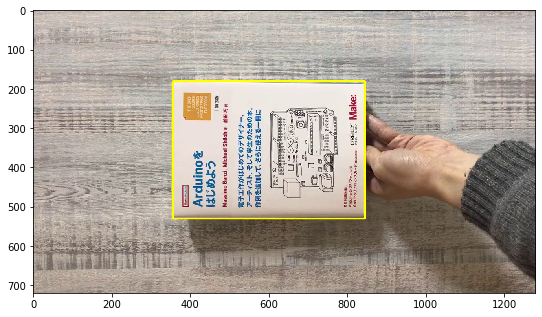

In [26]:
video_input_path  = "./first_frame_arduino.jpg"
img = cv2.imread(video_input_path)
bbox = np.array([[355, 181], [844, 181], [844, 530], [355, 530]]).reshape(-1,1,2)
#print(bbox)
img_bbox = cv2.polylines(img, [np.int32(bbox)], True, (0, 255, 255), 3, cv2.LINE_AA)
#print(img_bbox)
img_plt = cv2.cvtColor(img_bbox, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(9,9))
plt.imshow(img_plt)

### Try to draw a bbox on image

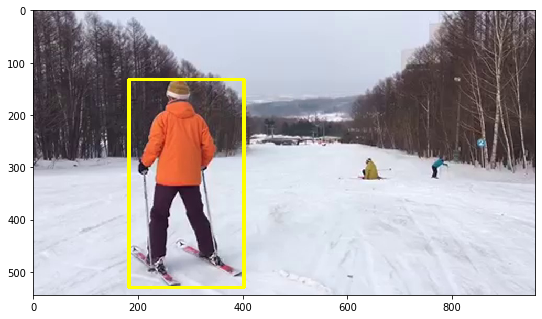

In [29]:
img = cv2.imread('./first_frame.jpg')
img_bbox = cv2.rectangle(img, (183, 132), (402, 529), (0, 255, 255), 5)
img_crop = img[132:519, 183:402, :]
cv2.imwrite('./crop_img.jpg', img_crop)
img_plt = cv2.cvtColor(img_bbox, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(9,9))
plt.imshow(img_plt)

## The real process of object tracking

In [30]:
def draw_bbox(img, xmin, ymin, xmax, ymax):
    # draw a bbox on to a image (in BGR format)
    # return: image with bbox
    img_bbox = cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 255), 5)
    return img_bbox

In [31]:
def ransac_match(kp_src, kp_target, thresh_size, iterations):
    # input: two groups of keypoints
    # return: homography, binary of inlier/outlier indexes
    kp_src    = np.array(kp_src)
    kp_target = np.array(kp_target)
    M, S = cv2.findHomography(kp_src, kp_target, cv2.RANSAC, thresh_size)
    return M, S

In [32]:
def detect_first_frame(frame, bbox_first):
    # Draw bbox on img
    xmin_1, ymin_1, xmax_1, ymax_1 = bbox_first
    frame_with_bbox = draw_bbox(frame, xmin_1, ymin_1, xmax_1, ymax_1)
    
    # Detect the keypoints and return them
    frame_crop = frame[xmin_1:xmax_1, ymin_1:ymax_1]
    sift = cv2.xfeatures2d.SIFT_create()
    kp_orig, des_orig = sift.computedetectAndCompute(frame_crop, None)
    return frame_with_bbox, kp_orig, des_orig

In [33]:
def sift_detect(frame, kp_orig, des_orig):
    thresh_size = 5   # let it to be self.
    iterations  = 100
    
    # Detect keypoints
    sift = cv2.xfeatures2d.SURF_create()
    kp, des = sift.computedetectAndCompute(frame, None)
    
    # Do matching with the previous frame's keypoints
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des_orig, des, k=2)     # or using DescriptorMatcher
    
    # Get the matched points
    match_points_pre  = []
    match_points_this = []
    for m, n in matches:
        img1_idx = m.queryIdx
        img2_idx = m.trainIdx
        (x1, y1) = kp_orig[img1_idx].pt
        (x2, y2) = kp[img2_idx].pt
        match_points_pre.append((int(x1), int(y1)))
        match_points_this.append((int(x2), int(y2)))

    # RANSAC to refine the matched points
    M, S = ransac_match(match_points_pre, match_points_this, thresh_size, iterations)
    
    x_min, y_min, x_max, y_max = 1000, 1000, 0, 0 
    S_list = S.tolist()
    match_final = []
    for i in range(len(S_list)):
        if S_list[i] == [1]:
            match_final.append(match_points_this[i])
            if match_points_this[i][0] < x_min:
                x_min = match_points_this[i][0]
            if match_points_this[i][1] < y_min:
                y_min = match_points_this[i][1]
            if match_points_this[i][0] > x_max:
                x_max = match_points_this[i][0]
            if match_points_this[i][1] > y_max:
                y_max = match_points_this[i][1]
                
    bbox_tracked = [x_min, y_min, x_max, y_max]
    # Perspect the original bbox
    # bbox_tracked = cv2.warpPerspective(bbox_pre, M)
    return bbox_tracked

In [35]:
def main():
    
    bbox_pre = [183, 132, 402, 529]
    count = 1
    video_orig = cv2.VideoCapture('./snow_board_resized.mp4')


    while(True):
        ret, frame = video_orig.read()
        if ret:
            if count == 1:
                frame_fisrt, kp_pre, des_pre = detect_first_frame(frame, bbox_pre)
                cv2.imshow("Traking Object", frame_fisrt)
                cv2.waitKey(25)
                count += 1    # after first we don't need count
            
            else:
                bbox_tracked = sift_detect(frame, kp_pre, des_pre)
                #kp_pre, des_pre, bbox_pre = kp, des, bbox_tracked
                xmin, ymin, xmax, ymax = bbox_tracked
                frame_tracked = draw_bbox(frame, xmin, ymin, xmax, ymax)
#                 out.write(frame_tracked)   # for saving video
                cv2.imshow('Traking Object',frame_tracked)
                if cv2.waitKey(25):
                    break
        else:
            break

    video_orig.release()
    cv2.destroyAllWindows()